# Segmentando clientes

experimento colaborativo

## Resumen, explicación del experimento

- tomo seis meses desde enero a junio de 2021
- uso bajas binarias (baja+1 y baja+2 vs continua)
- hago dos conjuntos 8000/2000 de casos uno con mayoria continua y otro con mayoría bajas.
- calculo la **distancia random forest** 
- calculo los clusters con hdbscan 
- obetngo medioides, los puntos reales más cercanos a los centroides
- por problemas de memoria en el próximo paso divido en lotes el dataset grande
- calculo las distancias random forest a esos medioides puntos de todo el dataset - *para toda la competenca*
- asigno cluster a cada punto según medioide más cercano
- hago esto en ambos conjuntos (mayoría bajas y mayoría continua)

- agrego las distancias calculadas al datset antes deL Feature Engeneering
- comparo resultados contra el pipeline estandar

En i5-4690K con 32 de RAM tarda ~ 40 minutos en calcular y 25 minutos en grabar + 10 minutos si queremos graficos para mirar que anda pasando


#### Configuración inicial

In [1]:
#%pip install scikit-learn==1.3.2
#%pip install seaborn==0.13.1
#%pip install numpy==1.26.4
#%pip install matplotlib==3.7.1
# %pip install umap
# %pip install umap-learn # en windows solo instalar umap-learn

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import sys
import polars as pl

from umap import UMAP
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.cluster import HDBSCAN
from sklearn.ensemble import  RandomForestClassifier
from sklearn.impute import SimpleImputer
from scipy.spatial import distance

### dicc de funciones

**armo_seleccion**: elijo cantidad de enfermos y continua para entrenar los modelos

**entreno_modelo**: en un modelo random forest de 200 arboles clasifica los puntos para encontrar las distancias rf

**distanceMatrix**: computo las distancias para el armado de clusters

**centroides_punto**: se usa en la funcion de grafico para ubicar centroides (fue antes de usar hdbscan)

**grafico_clusters**: grafica segun las etiquetas en una proyección umap da una idea remota de como se están armando los clusters

**restart_line**: reinicia la linea para el contador de avance de la funcion de distancias cuando uso lotes

**generar_lotes**: arma los lotes para la funcion de distancias cuando uso lotes

**calcular_proximidad_centroides**: toma puntos del df original y devuenlve las distancias a los centroides

**distancias_para_todos**: acomoda los datos para el calculo de proximidad y divide por lotes si hace falta

**a_df_para_unir**: prepara las distancias a los centroides y los datos de cluster para unir

**guardo_todo**: une los df con el original y guarda. pongo acá para que no se duplique todo en memoria siquiero seguir haciendo cosas


In [3]:
# Función para ubicar centroides en el grafico desde el umap y el dbscan
# util para gráfico y para medir distancia después

def centroides_punto(y, embedding_rf, sin_ruido=True):
    # Asignar las etiquetas de los clusters del DBSCAN
    labels = y
    
    # Crear un DataFrame con las etiquetas y los puntos
    df_clusters = pd.DataFrame(embedding_rf, columns=['x', 'y'])
    df_clusters['cluster'] = labels
    
    # Agrupar por cluster y calcular el centroide (media) de cada uno
    centroides = df_clusters.groupby('cluster').mean()

    # Cantidad de puntos por clúster
    cantidad = pd.Series(labels).value_counts()
    cantidad.index.rename('cluster', inplace=True)
    
    # Unir centroides con la cantidad de puntos por clúster
    centro_y_cantidad = pd.merge(centroides, cantidad, left_index=True, right_index=True)
    centro_y_cantidad.columns = ['centro_x', 'centro_y', 'count']

    if np.isin(-1, labels):
        # Filtrar ruido (clúster -1), si es necesario
        if sin_ruido:
            centro_y_cantidad = centro_y_cantidad[centro_y_cantidad['count'] > centro_y_cantidad.loc[-1, 'count']]
        else:
            centro_y_cantidad = centro_y_cantidad[centro_y_cantidad['count'] != centro_y_cantidad.loc[-1, 'count']]
    
    # Encontrar el punto más cercano al centroide para cada clúster
    punto_mas_cercano = {}
    for cluster in centro_y_cantidad.index:
        # Filtrar los puntos que pertenecen al clúster actual
        puntos_cluster = df_clusters[df_clusters['cluster'] == cluster]
        
        # Coordenadas del centroide del clúster
        centroide = centro_y_cantidad.loc[cluster, ['centro_x', 'centro_y']].values
        
        # Calcular la distancia de cada punto al centroide
        distancias = distance.cdist(puntos_cluster[['x', 'y']], [centroide], metric='euclidean').flatten()
        
        # Obtener el índice del punto más cercano
        indice_cercano = np.argmin(distancias)
        
        # Guardar el punto más cercano al centroide
        punto_mas_cercano[cluster] = puntos_cluster.iloc[indice_cercano]

    indice_punto = []
    p_x = []
    p_y = []
    for i in punto_mas_cercano:
        indice_punto.append(punto_mas_cercano[i].name)
        p_x.append(punto_mas_cercano[i].x)
        p_y.append(punto_mas_cercano[i].y)

    centro_y_cantidad['indice_punto'] = indice_punto
    centro_y_cantidad['p_x'] = p_x
    centro_y_cantidad['p_y'] = p_y
    return centro_y_cantidad

# función para graficar y entender la distribución y cantidades de los clusters
def grafico_clusters(y, embedding_rf, prob_baja, sin_ruido=False):
    
    fig, axs = plt.subplots(1,2, figsize=(16,8))
    
    scatter = axs[0].scatter(embedding_rf[:, 0], embedding_rf[:, 1], c=y, cmap='tab20', s=5, alpha=0.5)
    # produce a legend with the unique colors from the scatter
    legend1 = axs[0].legend(*scatter.legend_elements(),
                        loc="upper left", title="Grupo")
    axs[0].add_artist(legend1)
    axs[0].set_title('Grupos detectados')
    
    prop = axs[1].scatter(embedding_rf[:,0], embedding_rf[:,1], c=prob_baja, s=10,  cmap='bwr', alpha=0.2)
    fig.colorbar(prop, ax=axs[1] )
    axs[1].set_title('Probabilidad de baja')
    
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    
    centers = centroides_punto(y, embedding_rf, sin_ruido=sin_ruido)
    
    # Draw white circles at cluster centers
    axs[0].scatter(
        centers['centro_x'],
        centers['centro_y'],
        marker="o",
        c="white",
        alpha=1,
        s=150,
        edgecolor="k",
    )
    
    for i, c in enumerate(centers.T):
    
        axs[0].scatter(centers.T[c]['centro_x'], centers.T[c]['centro_y'], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
    
    fig.tight_layout()
    #fig.savefig('clusters.png', dpi=92)
    plt.show()


def entreno_modelo(Xtrain, ytrain, n_estimators=200):
    model = RandomForestClassifier(n_estimators=n_estimators, max_features=20, max_depth=4, min_samples_leaf=400, random_state=17 )
    model.fit(Xtrain, ytrain)
    return model

def distanceMatrix(model, X):

    terminals = model.apply(X)
    nTrees = terminals.shape[1]

    a = terminals[:,0]
    proxMat = 1*np.equal.outer(a, a)

    for i in range(1, nTrees):
        a = terminals[:,i]
        proxMat += 1*np.equal.outer(a, a)

    proxMat = proxMat / nTrees

    return proxMat.max() - proxMat

def armo_seleccion(Xtrain, ytrain, cant_cont, cant_enf):
    
    np.random.seed(17) 
    continua_sample = ytrain[ytrain == 0].sample(cant_cont).index
    bajas_1_2 = ytrain[ytrain == 1].sample(cant_enf).index
    rf_index = continua_sample.union(bajas_1_2)
    
    Xtrain_rf = Xtrain.loc[rf_index]
    ytrain_rf = ytrain.loc[rf_index]
    
    imp_mean = SimpleImputer(missing_values=np.nan, strategy='median')
    Xtrain_rf_imp = imp_mean.fit_transform(Xtrain_rf.iloc[:,2:]) # saco numero de cliente y foto-mes
    return Xtrain_rf_imp, ytrain_rf, Xtrain_rf, imp_mean



# armos funciones de loop y lotes para procesar todo el dataset.
# hay que ver que onda cuano queramos correr más meses

def a_df_para_unir(distancias_centroides, custer_por_cerc, sufijo='enf'):
    cols =[]
    for col in range(distancias_centroides.shape[1]):
        cols.append(f'clust_{sufijo}_{col}')
    
    df_clus = pd.DataFrame(distancias_centroides, columns=cols)
    df_clus[f'clust_{sufijo}'] = custer_por_cerc
    return df_clus

def restart_line():
    sys.stdout.write('\r')
    sys.stdout.flush()

def generar_lotes(puntos, tamaño_lote):
    """
    Divide los puntos en lotes más pequeños para procesar.
    
    :param puntos: Array o DataFrame con todos los puntos
    :param tamaño_lote: Tamaño de cada lote
    :yield: Un lote de puntos
    """
    for i in range(0, len(puntos), tamaño_lote):
        yield puntos[i:i + tamaño_lote]

# acá calculo la distancia random forest (en el modelo que entrené antes)
# la diferencia es que permite dos grupos de puntos

def calcular_proximidad_centroides(model, puntos_nuevos, centroides):
    """
    Calcula la proximidad basada en bosques aleatorios entre puntos nuevos y los centroides.

    :param model: Modelo de bosque aleatorio (RandomForest) ya entrenado
    :param puntos_nuevos: DataFrame o array con los puntos nuevos (n_rows, n_dims)
    :param centroides: DataFrame o array con los centroides (6, n_dims)
    
    :return: DataFrame con la proximidad entre cada punto nuevo y cada uno de los centroides
    """
    
    # Aplicar el modelo a los puntos nuevos y los centroides para obtener las hojas terminales
    terminales_nuevos = model.apply(puntos_nuevos)
    terminales_centroides = model.apply(centroides)
    # Elimino columnas de puntos duplicados después de rf
    terminales_centroides = np.unique(terminales_centroides, axis=0)
    
    # Obtener el número de árboles en el modelo
    nTrees = terminales_nuevos.shape[1]
    
    # Inicializar la matriz de proximidad
    proximidad = np.zeros((puntos_nuevos.shape[0], terminales_centroides.shape[0]))
    
    # Calcular la proximidad entre cada punto nuevo y cada centroide
    for i in range(nTrees):
        # Compara los terminales de los puntos nuevos con los terminales de los centroides para cada árbol
        iguales = np.equal.outer(terminales_nuevos[:, i], terminales_centroides[:, i])
        proximidad += iguales
   
    # Normalizar por el número de árboles
    proximidad = proximidad / nTrees

    return proximidad.max() - proximidad

# Encapsulo la función anterior preparando el dataset general


def distancias_para_todos(df_base, centroides, model, imp_mean, clase_ternaria=False, tamaño_lote=0):
    if clase_ternaria:
        df_base = df_base.drop("clase_ternaria", axis=1)
    df_base = df_base.iloc[:,2:]
    
     # saco numero de cliente y fotomes
    centroides = imp_mean.transform(centroides.iloc[:,2:])
        
    if tamaño_lote != 0:

        acumulador_distancias = []
        cont = 0
        total = len(df_base.iloc[:,:-1])
    
        for lote_puntos in generar_lotes(df_base, tamaño_lote):

            todos_los_puntos = imp_mean.transform(lote_puntos)

            #contador
            cont = cont + tamaño_lote
            perc = (cont/total)*100       
            sys.stdout.write(f'porcentaje:{perc:,.01f}')
            sys.stdout.flush()
            restart_line()

            distancias_lote = calcular_proximidad_centroides(model, todos_los_puntos, centroides)

            
            acumulador_distancias.append(distancias_lote)

        return np.vstack(acumulador_distancias)

def calcular_proximidad_centroides_sin_md(puntos_nuevos, centroides):
    """
    Calcula la proximidad basada en distancias euclidianas entre puntos nuevos y los centroides.
    
    :param puntos_nuevos: DataFrame o array con los puntos nuevos (n_rows, n_dims)
    :param centroides: DataFrame o array con los centroides (6, n_dims)
    
    :return: array con la proximidad entre cada punto nuevo y cada uno de los centroides
    """
    
    # Convertimos los datos a arrays de numpy
    terminales_nuevos = np.array(puntos_nuevos)
    terminales_centroides = np.array(centroides)
    
    # Eliminar filas duplicadas en los centroides
    terminales_centroides = np.unique(terminales_centroides, axis=0)

    # Verificación de valores NaN o infinitos
    if np.isnan(terminales_nuevos).any() or np.isinf(terminales_nuevos).any():
        print("Advertencia: Se encontraron valores NaN o infinitos en los puntos nuevos.")
        terminales_nuevos = np.nan_to_num(terminales_nuevos, nan=0.0, posinf=0.0, neginf=0.0)

    if np.isnan(terminales_centroides).any() or np.isinf(terminales_centroides).any():
        print("Advertencia: Se encontraron valores NaN o infinitos en los centroides.")
        terminales_centroides = np.nan_to_num(terminales_centroides, nan=0.0, posinf=0.0, neginf=0.0)

    # Calculamos las distancias
    distances = cdist(terminales_nuevos, terminales_centroides, metric='euclidean')

    return distances


# Encapsulo la función anterior preparando el dataset general


def distancias_para_todos_sin_md(df_base, centroides, imp_mean, clase_ternaria=False, tamaño_lote=0):
    if clase_ternaria:
        df_base = df_base.drop("clase_ternaria", axis=1)
    df_base = df_base.iloc[:,2:]
    
     # saco numero de cliente y fotomes
    centroides = imp_mean.transform(centroides.iloc[:,2:])
        
    if tamaño_lote != 0:

        acumulador_distancias = []
        cont = 0
        total = len(df_base.iloc[:,:-1])
    
        for lote_puntos in generar_lotes(df_base, tamaño_lote):

            todos_los_puntos = imp_mean.transform(lote_puntos)

            #contador
            cont = cont + tamaño_lote
            perc = (cont/total)*100       
            sys.stdout.write(f'porcentaje:{perc:,.01f}')
            sys.stdout.flush()
            restart_line()

            distancias_lote = calcular_proximidad_centroides_sin_md(todos_los_puntos, centroides)

            
            acumulador_distancias.append(distancias_lote)

        return np.vstack(acumulador_distancias)
            
    else:
        todos_los_puntos = imp_mean.transform(df_base) # saco numero de cliente y fotomes
        distancias_centroides = calcular_proximidad_centroides_sin_md(todos_los_puntos, centroides)
    
    return distancias_centroides


#también solo útil para graficos
def probabilidad_de_baja(model, Xtrain):
    class_index = np.where(model.classes_ == 1)[0]
    prob_baja = model.predict_proba(Xtrain)[:,class_index]
    return prob_baja


def asignar_clusters_con_umbral(matriz_distancias, umbral):
    """
    Asigna el clúster más cercano a cada punto usando la matriz de distancias,
    aplicando un umbral para determinar si está demasiado lejos de todos los centroides.
    
    :param matriz_distancias: Array de tamaño (n_puntos, n_centroides) con las distancias a los centroides
    :param umbral: Distancia máxima permitida para asignar un punto a un clúster.
    
    :return: Array de tamaño (n_puntos,) donde cada elemento es el índice del centroide más cercano
             o -1 si está fuera del umbral.
    """
    
    # Encuentra el índice del centroide más cercano para cada punto
    indices_centroides_mas_cercanos = np.argmin(matriz_distancias, axis=1)
    
    # Encuentra la distancia mínima a los centroides para cada punto
    distancias_minimas = np.min(matriz_distancias, axis=1)
    
    # Asigna -1 a los puntos cuya distancia mínima es mayor que el umbral
    asignaciones = np.where(distancias_minimas <= umbral, indices_centroides_mas_cercanos, -1)

    return asignaciones



In [4]:
base_path = 'E:/Users/Piquelin/Documents/Maestría_DataMining/Economia_y_finanzas/'
# base_path = 'C:/Users/jfgonzalez/Documents/documentación_maestría/economía_y_finanzas/'
# base_path = '~/buckets/b1/'
dataset_path = base_path + 'datasets/'
modelos_path = base_path + 'modelos/'
# dataset_file = 'competencia_01.csv'
# dataset_file = 'resultado_sin_prestamos.csv'
dataset_file = 'competencia_02.parquet'
# dataset_file_2 = 'C:/Users/jfgonzalez/Documents/documentación_maestría/economía_y_finanzas/exp/expw_TS-0002_dataset_train_final.csv.gz'

In [5]:
%%time
# df_base = pd.read_csv(dataset_path + dataset_file, low_memory=False)
df_base = pd.read_parquet(dataset_path + dataset_file)

CPU times: total: 18.2 s
Wall time: 5.45 s


In [6]:
# df_base = pd.read_csv(dataset_file_2)

#### empiezo

In [7]:
Xtrain = df_base[df_base['foto_mes'].isin([202101, 202102, 202103, 202104])] # , 202105, 202106
# Xtrain = df_base[df_base['foto_mes'].isin([202104, 202103, 202102, 202101, 202012, 202011, 202010, 202009, 202008, 202007, 202005, 202004])]

A su vez, nos concentraremos en el fenómeno de la **baja**. No importa si es en un mes o si es en dos.

In [8]:
ytrain = Xtrain["clase_ternaria"].map(lambda x: 0 if x == "CONTINUA" else 1)

# elijo solo baja+2
# ytrain = Xtrain["clase_ternaria"].map(lambda x: 1 if x == "BAJA+2" else 0)

Xtrain = Xtrain.drop("clase_ternaria", axis=1)

In [9]:
ytrain.value_counts()

clase_ternaria
0    645039
1      7408
Name: count, dtype: int64

In [10]:
Xtrain_4m, ytrain_4m, X_para_medioid_4m, imp_mean_4m= armo_seleccion(Xtrain, ytrain, cant_cont=7400, cant_enf=7408)

In [11]:
# elimino subdataset para vaciar memoria
del Xtrain, ytrain

In [12]:
%%time
hdb_4m = HDBSCAN(min_cluster_size=20, min_samples=30, n_jobs=-1, store_centers='both')
y_4m = hdb_4m.fit(Xtrain_4m)

CPU times: total: 43.7 s
Wall time: 24.3 s


In [28]:
%%time
from sklearn.cluster import AffinityPropagation

af = AffinityPropagation(random_state=17, max_iter=50).fit(Xtrain_4m)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_
# 500 20 min
# 200 11 min

E:\Users\Piquelin\anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:142: ConvergenceWarning: Affinity propagation did not converge, this model may return degenerate cluster centers and labels.
  warnings.warn(


CPU times: total: 3min 7s
Wall time: 3min 11s


In [42]:
cluster_detectados = pd.Series(labels).value_counts()
# cluster_detectados[cluster_detectados <= 100].index

labels_rec = pd.Series(labels).replace(cluster_detectados[cluster_detectados <= 100].index, -1)
labels_rec.value_counts()

-1       8658
 26      1432
 548      405
 510      367
 752      329
 229      317
 1003     316
 1092     237
 817      226
 305      222
 906      221
 350      219
 1218     187
 761      175
 446      161
 404      156
 813      155
 1176     133
 657      122
 1221     115
 565      114
 696      111
 253      110
 87       110
 820      105
 507      105
Name: count, dtype: int64

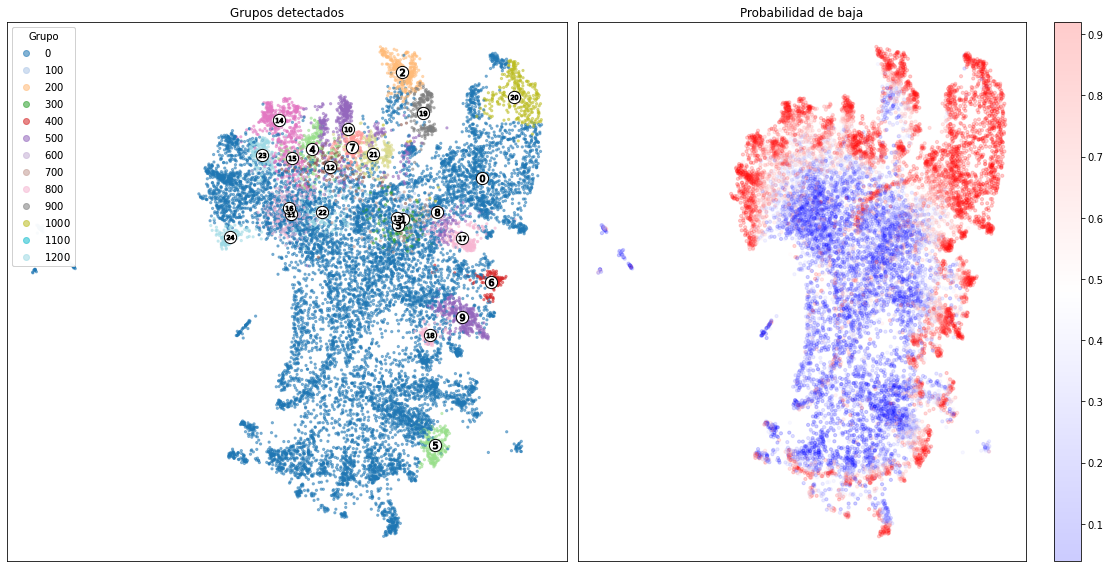

CPU times: total: 1.19 s
Wall time: 1.19 s


In [43]:
%%time
# separo el grafico por si eligo hacerlo ciego
grafico_clusters(labels_rec, embedding_4m, prob_baja_4m, sin_ruido=False)

In [13]:
%%time
model_4m = entreno_modelo(Xtrain_4m, ytrain_4m, n_estimators=200)
prob_baja_4m = probabilidad_de_baja(model_4m, Xtrain_4m)

CPU times: total: 3.64 s
Wall time: 3.65 s


Por la alta dimensionalidad (10.000 columnas) uso hdbscan que explora buscando cluisters de densidad variable

In [14]:
%%time
# paso de mediodes en el modelo a casos reales

medioid_4m = hdb_4m.medoids_
# Encontrar las filas en matriz_10000 que coinciden con alguna fila en 'puntos'
indices_4m = [i for i in range(Xtrain_4m.shape[0]) if any(np.array_equal(Xtrain_4m[i], fila) for fila in medioid_4m)]
# me puede devolver más de los mediodes reales por puntos superpuestos, que sean siempre clasificados en el mismo punto.
# por ahora los tomo (no son muchos) y los filtro más adelante
print("Índices de las filas coincidentes:", indices_4m)
medioid_4m = X_para_medioid_4m.iloc[indices_4m]
del indices_4m

Índices de las filas coincidentes: [165, 211, 1130, 1578, 1604, 2312, 3461, 3614, 4822, 4993, 5408, 5908, 6230, 9067, 9382, 9803, 9859, 10006, 10421, 11624, 11860, 12284, 12318, 12353, 13919, 14459, 14693]
CPU times: total: 1.47 s
Wall time: 1.47 s


In [15]:
%%time
import numpy as np
from scipy.spatial.distance import cdist
#sin visualizacion calculo distancias y asigno clusters para todo el dataset
distancias_centroides_4m = distancias_para_todos_sin_md(df_base, medioid_4m, imp_mean_4m,  clase_ternaria=True, tamaño_lote=1000)
custer_por_cerc_4m = np.argmin(distancias_centroides_4m, axis=1)

df_clus_4m = a_df_para_unir(distancias_centroides_4m, custer_por_cerc_4m, sufijo='4m')
df_clus_4m.head()

CPU times: total: 1min 43s
Wall time: 1min 41s


,clust_4m_0,clust_4m_1,clust_4m_2,clust_4m_3,clust_4m_4,clust_4m_5,clust_4m_6,clust_4m_7,clust_4m_8,clust_4m_9,clust_4m_10,clust_4m_11,clust_4m_12,clust_4m_13,clust_4m_14,clust_4m_15,clust_4m_16,clust_4m_17,clust_4m_18,clust_4m_19,clust_4m_20,clust_4m_21,clust_4m_22,clust_4m_23,clust_4m_24,clust_4m_25,clust_4m_26,clust_4m
0,427873.174986,6.982337e+05,475042.317357,1.324008e+06,414860.349796,8.491730e+05,422949.222660,473180.755659,427374.997411,571462.179024,429018.987954,536593.651109,2.341093e+06,447715.904247,492893.556262,1.032442e+06,567627.781017,469579.685714,404913.453394,417875.037946,408000.501070,443268.489686,4.110491e+07,5.170995e+06,513954.862791,7.109501e+06,460159.618958,18
1,278758.928175,9.766122e+05,208519.977419,1.665933e+06,330574.488448,1.033253e+06,551769.634785,178494.967293,541858.656384,823220.869804,278591.654673,94472.827177,2.713579e+06,227804.739366,149327.958274,1.356210e+06,803406.993769,647472.126789,365813.991268,305803.737035,435473.155759,234054.182426,4.126741e+07,5.486735e+06,205606.990572,7.508540e+06,235534.484740,11
2,153537.276095,8.085576e+05,213215.581600,1.495000e+06,190890.121798,8.361492e+05,420718.580970,121986.460269,380953.914796,683252.528295,149349.433147,170972.136939,2.540863e+06,127971.774902,161134.129932,1.186154e+06,637282.905473,484103.780949,257982.255658,187298.762287,281901.493119,171083.245243,4.113846e+07,5.289645e+06,85967.235106,7.333964e+06,92858.228451,24
3,277462.981989,9.809938e+05,184255.059290,1.671310e+06,330496.227465,1.052427e+06,547678.854809,172071.024248,543755.698056,820408.818410,276992.501793,72209.871378,2.719414e+06,224577.500779,128171.069956,1.361283e+06,807360.774037,650649.110776,358630.278048,302197.393153,437016.987339,222828.443214,4.128628e+07,5.507439e+06,218903.894493,7.515538e+06,238202.888407,11
4,347127.057859,1.032771e+06,279046.717734,1.720032e+06,396740.933197,1.079246e+06,613080.394406,251701.689153,602434.695762,880898.602507,346272.380593,172481.427268,2.765352e+06,298601.441540,224609.563881,1.411017e+06,861283.799759,706285.279986,430915.082544,373648.060576,498547.899876,305140.987579,4.128750e+07,5.528266e+06,265786.932142,7.557168e+06,301084.364247,11


In [16]:
df_clus_4m[df_clus_4m.clust_4m == 24]['clust_4m_24'].max()

48231392.18274694

In [17]:
# clusters hasta un umbral de distancia y si no -1
umbral = 100000  # Define el umbral de distancia

# Asigna los clusters según el umbral
asignaciones = asignar_clusters_con_umbral(distancias_centroides_4m, umbral)

In [18]:
df_clus_4m["asignaciones"] = asignaciones
pd.concat([df_clus_4m["asignaciones"].value_counts(), df_clus_4m.clust_4m.value_counts()], axis=1)

,count,count
-1,3712703,NaN
11,340040,1191743.0
14,103919,320690.0
10,94952,331753.0
20,65963,306727.0
24,61027,156186.0
7,52165,185328.0
4,38670,163439.0
2,34160,125003.0
0,33137,186028.0


##### Guardo

In [19]:
%%time
def guardo_todo(df_base, df_clus_4m, dataset_path):

    nueva_base = pd.concat([df_base, df_clus_4m], axis=1)
    nueva_base.to_csv(dataset_path + 'competencia_02_clust4_affprop.csv.gz', compression='gzip')
    nueva_base.to_parquet(dataset_path + 'competencia_02_clust4_affprop.parquet')
    print('listo')
    return None


guardo_todo(df_base, df_clus_4m, dataset_path)

listo
CPU times: total: 19min 6s
Wall time: 19min 17s


## Gráficos

CPU times: total: 1min 17s
Wall time: 1min 14s


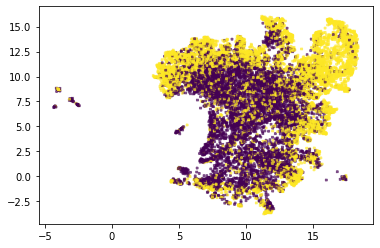

In [20]:
%%time
# este paso es para graficar y ver que está pasando no es necesario si no queremos gráficos
# Separo el fit del transform para mayor claridad
umap_4m = UMAP(
  n_components=2,
  n_neighbors=150,
  min_dist=0.6,
  metric="euclidean", #  precomputed no permite convertir nuevos puntos
  random_state=17,
  n_jobs=1 # porque fijo semilla
).fit(Xtrain_4m)

embedding_4m = umap_4m.embedding_

plt.scatter(embedding_4m[:,0], embedding_4m[:,1], c=ytrain_4m, s=5, alpha=0.7, marker='x')

In [ ]:
labels

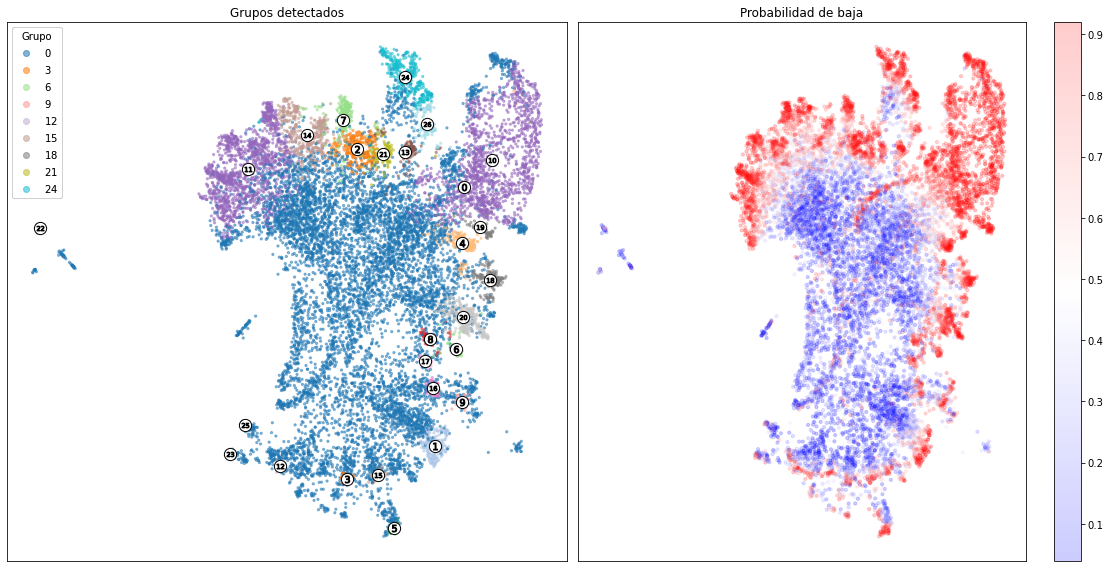

CPU times: total: 1.45 s
Wall time: 1.45 s


In [22]:
%%time
# para ver con dataset chico
# finalmente calculo el primer set de distancias randomf forest con los puntos más cercanos a los centroides
distancias_centroides_4m_g = distancias_para_todos_sin_md(X_para_medioid_4m , medioid_4m, imp_mean_4m)
custer_por_cerc_4m = asignar_clusters_con_umbral(distancias_centroides_4m_g, umbral=100000)
grafico_clusters(custer_por_cerc_4m, embedding_4m, prob_baja_4m, sin_ruido=False) 
# oportunidad de mejora contrastar con el anterior